In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt 
import snowflake.connector
import datetime
import seaborn as sns

In [2]:
ctx = snowflake.connector.connect(
    user='USER',
    password='PASS',
    account='ACC',
)

In [3]:
# issortinti pagal data pirmaq
# SQL query
query = '''
SELECT * FROM COVID19_EPIDEMIOLOGICAL_DATA.PUBLIC.CT_US_COVID_TESTS where  
Date between '2020-03-01' and '2021-03-01'
order by date;
'''

# Execute the query and fetch the result into a Pandas DataFrame
result = ctx.cursor().execute(query)
df = pd.DataFrame(result.fetchall(), columns=[col[0] if isinstance(col, tuple) else col for col in result.description])

In [4]:
df.head(5)

,COUNTRY_REGION,PROVINCE_STATE,DATE,POSITIVE,POSITIVE_SINCE_PREVIOUS_DAY,NEGATIVE,NEGATIVE_SINCE_PREVIOUS_DAY,PENDING,PENDING_SINCE_PREVIOUS_DAY,DEATH,...,HOSPITALIZEDCUMULATIVE,HOSPITALIZEDCUMULATIVEINCREASE,INICUCURRENTLY,INICUCURRENTLYINCREASE,INICUCUMULATIVE,INICUCUMULATIVEINCREASE,ONVENTILATORCURRENTLY,ONVENTILATORCURRENTLYINCREASE,ONVENTILATORCUMULATIVE,ONVENTILATORCUMULATIVEINCREASE
0,United States,Michigan,2020-03-01,14.0,0,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,United States,Florida,2020-03-01,0.0,0,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,United States,New Jersey,2020-03-01,NaN,0,NaN,0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,United States,Washington,2020-03-01,26.0,8,NaN,0,NaN,NaN,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United States,Virginia,2020-03-01,NaN,0,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
series = df[["DATE", "DEATH_SINCE_PREVIOUS_DAY"]]
series = series[series['DEATH_SINCE_PREVIOUS_DAY'] >= 0]
series.dropna(subset=['DEATH_SINCE_PREVIOUS_DAY'])

,DATE,DEATH_SINCE_PREVIOUS_DAY
0,2020-03-01,0
1,2020-03-01,0
2,2020-03-01,0
3,2020-03-01,3
4,2020-03-01,0
...,...,...
20247,2021-03-01,0
20248,2021-03-01,59
20249,2021-03-01,0
20250,2021-03-01,0


In [6]:
series.index = pd.to_datetime(series['DATE'], format='%Y-%m-%d')

In [9]:
print(series)

            DEATH_SINCE_PREVIOUS_DAY
DATE                                
2020-03-01                         0
2020-03-01                         0
2020-03-01                         0
2020-03-01                         3
2020-03-01                         0
...                              ...
2021-03-01                         0
2021-03-01                        59
2021-03-01                         0
2021-03-01                         0
2021-03-01                         5

[20183 rows x 1 columns]


In [8]:
del series['DATE']

In [130]:
sns.set()

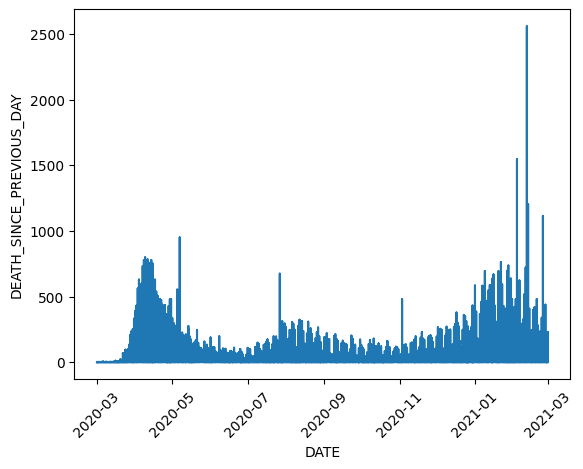

In [10]:
plt.ylabel('DEATH_SINCE_PREVIOUS_DAY')
plt.xlabel('DATE')
plt.xticks(rotation=45)
plt.plot(series.index, series['DEATH_SINCE_PREVIOUS_DAY'], )

In [11]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

Test RMSE: 84.938


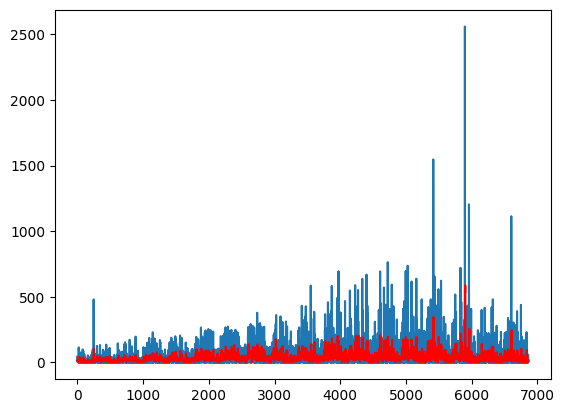

In [15]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()